### Objective  : To evaluate different retrievers used in llm-graph-builder application using RAGAS library

In [ ]:
#Installation 
#Other packages can be installed from requirement.txt

!pip install ragas==0.1.14 seaborn

### Pre requisites to run this notebook
A pdf file to be kept in files folder and same has to be uploaded in llm-graph-builder application

In [1]:
#importing all necessary packages
#keeping this notebook in experiements folder 
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
sys.path.append(os.path.abspath('../backend'))
from src.llm import get_llm
from src.QA_integration import QA_RAG, create_neo4j_chat_message_history,get_chat_mode_settings,get_neo4j_retriever,create_document_retriever_chain,retrieve_documents,format_documents,clear_chat_history
from langchain_core.messages import HumanMessage
from langchain_community.graphs import Neo4jGraph
from langchain_community.document_loaders import DirectoryLoader
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from datasets import Dataset, Features, Sequence, Value
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context

/workspaces/llm-graph-builder/backend/src/shared/common_fn.py:89: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embeddings = SentenceTransformerEmbeddings(
/opt/conda/envs/myenv310/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
#Check version of libraries installed as it is crucial to have specific version to run the code in codespace
### Python version :  3.10.14
### Ragas version :  0.1.14
### langchain version :  0.2.14
import sys
import ragas
import langchain
print("Python version : ",sys.version)
print("Ragas version : ", ragas.__version__)
print("langchain version : ", langchain.__version__)

Python version :  3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
Ragas version :  0.1.14
langchain version :  0.2.14


In [3]:

#Loading environmental variables
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
uri = os.getenv("NEO4J_URI")
userName = os.getenv("NEO4J_USERNAME")
password = os.getenv("NEO4J_PASSWORD")
database = os.getenv("NEO4J_DATABASE")

In [5]:
#Loading file kept in files folder through langchain loader
# Here we are using "About Amazon.pdf"
loader = DirectoryLoader("files")
documents = loader.load() 

/opt/conda/envs/myenv310/lib/python3.10/site-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


If above code gives error in codespace then run following commands in terminal 

sudo apt-get update

sudo apt-get install -y libgl1-mesa-glx 

pip install opencv-python

pip install typing 

then restart the kernel

In [6]:
#Generating synthetic test set through RAGAS library

generator_llm = ChatOpenAI(model="gpt-4")
critic_llm = ChatOpenAI(model="gpt-4")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

try: 
    testset = generator.generate_with_langchain_docs(documents, test_size=15, distributions={simple:0.3, reasoning: 0.3, multi_context: 0.4})
except Exception as e:
    print("Error: ",e)

Generating: 100%|██████████| 15/15 [03:48<00:00, 15.21s/it]


In [7]:
#Creating dataframe from generated test set

generated_testdf = testset.to_pandas()
generated_testdf.head()

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What issues did Amazon's Elastic Block Storage...,[�s largest book retailer operating both onlin...,"In 2012, Amazon's Elastic Block Storage (EBS) ...",simple,[{'source': 'files/About Amazon.pdf'}],True
1,How does the integrated focused cost leadershi...,[�s largest book retailer operating both onlin...,The integrated focused cost leadership/differe...,simple,[{'source': 'files/About Amazon.pdf'}],True
2,What is the competitive strategy of Barnes and...,[ online advertising and the security of consu...,The answer to given question is not present in...,simple,[{'source': 'files/About Amazon.pdf'}],True
3,Why should online retailers like Amazon be car...,[ online advertising and the security of consu...,Online retailers like Amazon should be careful...,simple,[{'source': 'files/About Amazon.pdf'}],True
4,How threatening are substitute products to Ama...,[ online advertising and the security of consu...,The threat of substitutes for Amazon is high. ...,reasoning,[{'source': 'files/About Amazon.pdf'}],True


In [8]:
generated_testdf['question'].to_list()

["What issues did Amazon's Elastic Block Storage (EBS) service face in 2012 and how did it affect the company?",
 'How does the integrated focused cost leadership/differentiation strategy help competitors compete with Amazon in the book industry?',
 'What is the competitive strategy of Barnes and Noble in the e-commerce industry?',
 'Why should online retailers like Amazon be careful about disclosing online sales taxes in their advertisements?',
 "How threatening are substitute products to Amazon's patented tech and customer service?",
 "What was the 2012 issue with Amazon's EBS and its proposed fix?",
 "What strategy led to Amazon's growth from a small bookstore to a $48B retail giant?",
 'What strategic shift helped Amazon evolve from a small bookstore to a $48B retail giant?',
 "How has Amazon's M&A strategy, transitioning from an online bookstore to a multi-category platform, been shaped by competition?",
 "What strategies are Amazon's book competitors using for market share and ho

#### Questions are of following types

Simple : Straight forward question from the context

Reasoning: Rewrite the question in a way that enhances the need for reasoning to answer it effectively.

Multi-Context: Rephrase the question in a manner that necessitates information from multiple related sections or chunks to formulate an answer.

In [113]:
generated_testdf['evolution_type'].value_counts()

evolution_type
multi_context    6
reasoning        5
simple           4
Name: count, dtype: int64

In [10]:
#Optional - Saving generated testset for further use

generated_testdf.to_csv("RAGAS_testset.csv",index= False)

In [16]:
#Optional if you are re running code you can start from here
#generated_testdf = pd.read_csv("RAGAS_testset.csv")

### Now we will call our QnA bot to answer same questions that are generated through test set

In [17]:
def create_graph_database_connection(uri, userName, password, database):
  enable_user_agent = os.environ.get("ENABLE_USER_AGENT", "False").lower() in ("true", "1", "yes")
  if enable_user_agent:
    graph = Neo4jGraph(url=uri, database=database, username=userName, password=password, refresh_schema=False, sanitize=True,driver_config={'user_agent':os.environ.get('NEO4J_USER_AGENT')})  
  else:
    graph = Neo4jGraph(url=uri, database=database, username=userName, password=password, refresh_schema=False, sanitize=True)    
  return graph

In [18]:
#Graph connection
graph = create_graph_database_connection(uri, userName, password, database)

#Chat modes
CHAT_VECTOR_MODE = "vector"
CHAT_FULLTEXT_MODE = "fulltext"
CHAT_ENTITY_VECTOR_MODE = "entity search+vector"
CHAT_VECTOR_GRAPH_MODE = "graph+vector"
CHAT_VECTOR_GRAPH_FULLTEXT_MODE = "graph+vector+fulltext"
CHAT_GLOBAL_VECTOR_FULLTEXT_MODE = "global search+vector+fulltext"

Modes = [CHAT_VECTOR_MODE,CHAT_FULLTEXT_MODE,CHAT_ENTITY_VECTOR_MODE,CHAT_VECTOR_GRAPH_MODE,CHAT_VECTOR_GRAPH_FULLTEXT_MODE,CHAT_GLOBAL_VECTOR_FULLTEXT_MODE]


In [19]:
#Creating list of questions from generated testset
Questions = generated_testdf['question'].to_list()
Questions

["What issues did Amazon's Elastic Block Storage (EBS) service face in 2012 and how did it affect the company?",
 'How does the integrated focused cost leadership strategy help competitors compete with Amazon in the book industry?',
 'What is the competitive strategy of Barnes and Noble in the e-commerce industry?',
 'Why should online retailers like Amazon be careful about disclosing online sales taxes in their advertisements?',
 "How threatening are substitute products to Amazon's patented tech and customer service?",
 "What was the 2012 issue with Amazon's EBS and its proposed fix?",
 "What strategy led to Amazon's growth from a small bookstore to a $48B retail giant?",
 'What strategic shift helped Amazon evolve from a small bookstore to a $48B retail giant?',
 "How has Amazon's M and A strategy, transitioning from an online bookstore to a multi-category platform, been shaped by competition?",
 "What strategies are Amazon's book competitors using for market share and how does it co

In [20]:
def fetch_context(mode,session_id,question):
    history = create_neo4j_chat_message_history(graph, session_id)
    messages = history.messages
    user_question = HumanMessage(content=question)
    messages.append(user_question)
    model = 'openai-gpt-3.5'
    document_names = '[]'
    llm, model_name = get_llm(model=model)
    chat_mode_settings = get_chat_mode_settings(mode=mode)
    retriever = get_neo4j_retriever(graph=graph, chat_mode_settings=chat_mode_settings, document_names=document_names)
    doc_retriever = create_document_retriever_chain(llm, retriever)
    docs = retrieve_documents(doc_retriever, messages) 
    context = format_documents(docs, model)
    return context[0]

In [22]:
def test_chatbot_qna(uri, userName, password,database, model_name, mode, question):
   """Test chatbot QnA functionality for different modes."""
   print(question,mode)
   session_id = int(Modes.index(mode)+1)
   graph = create_graph_database_connection(uri, userName, password, database) 
   clear_chat_history(graph, session_id)
   QA_n_RAG = QA_RAG(graph, model_name, question, '[]', session_id, mode)
   generated_context = fetch_context(mode,session_id,question)
   try:
       assert len(QA_n_RAG['message']) > 20
       return QA_n_RAG['message'],generated_context
   except AssertionError as e:
       print("Failed for mode : ",mode," session id :",session_id, "Error : ", e)
       return QA_n_RAG

In [23]:
def process_qna_pair(question, mode):  
   answer,generated_context = test_chatbot_qna(uri, userName, password,database,model_name='openai-gpt-3.5', mode=mode, question=question)
   return question, mode, answer,generated_context

In [ ]:
#This cell may take few minutes based on no of question and modes

results = []
results = [process_qna_pair(question, mode) for question in Questions for mode in Modes]

In [102]:
retrieved_df = pd.DataFrame(results, columns=['question', 'mode', 'answer','application_context'])
retrieved_df.head()

,question,mode,answer,application_context
0,What issues did Amazon's Elastic Block Storage...,vector,Amazon's Elastic Block Storage (EBS) service f...,Document start\nThis Document belongs to the s...
1,What issues did Amazon's Elastic Block Storage...,fulltext,Amazon's Elastic Block Storage (EBS) service f...,Document start\nThis Document belongs to the s...
2,What issues did Amazon's Elastic Block Storage...,entity search+vector,"In 2012, Amazon's Elastic Block Storage (EBS) ...",Document start\nThis Document belongs to the s...
3,What issues did Amazon's Elastic Block Storage...,graph+vector,Amazon's Elastic Block Storage (EBS) service f...,Document start\nThis Document belongs to the s...
4,What issues did Amazon's Elastic Block Storage...,graph+vector+fulltext,Amazon's Elastic Block Storage (EBS) service f...,Document start\nThis Document belongs to the s...


Some of the asnwers given by bot are not appropriate

In [45]:
retrieved_df[retrieved_df['answer'].str.lower().str.startswith("i don't have")]

,question,mode,answer,application_context
5,What issues did Amazon's Elastic Block Storage...,global search+vector+fulltext,I don't have that specific information availab...,Document start\nThis Document belongs to the s...
35,What was the 2012 issue with Amazon's EBS and ...,global search+vector+fulltext,I don't have that information right now. Is th...,Document start\nThis Document belongs to the s...
80,What were the 2012 issues with Amazon's EBS at...,entity search+vector,I don't have specific information regarding th...,Document start\nThis Document belongs to the s...
83,What were the 2012 issues with Amazon's EBS at...,global search+vector+fulltext,I don't have that information right now. Would...,Document start\nThis Document belongs to the s...


Important : Above result shows certain questions were not answered by QnA bot.

#Further analysis needs to be done here

In [47]:
#We will only consider proper answers for analysis

retrieved_df = retrieved_df[~retrieved_df['answer'].str.lower().str.startswith("i don't have")]
retrieved_df.to_csv('chatbot_answers.csv', index=False)
retrieved_df.shape

(86, 4)

In [33]:
#Optional if you are running code from here you can uncomment

# retrieved_df = pd.read_csv("chatbot_answers.csv")
# retrieved_df.head()

In [54]:
generated_testdf = generated_testdf.rename(columns={'contexts':'RAGAS_context'})

In [55]:
print("Generated test set columns : ",generated_testdf.columns)
print("QnA Bot Retrieved set columns: ",retrieved_df.columns)

Generated test set columns :  Index(['question', 'RAGAS_context', 'ground_truth', 'evolution_type',
       'metadata', 'episode_done'],
      dtype='object')
QnA Bot Retrieved set columns:  Index(['question', 'mode', 'answer', 'application_context'], dtype='object')


In [56]:
final_df = pd.merge(retrieved_df,generated_testdf,on='question',how='left')
final_df.shape

(86, 9)

In [57]:
#optional code if next cell is giving error as "ValueError: Dataset feature "contexts" should be of type Sequence[string]"ArithmeticError

# final_df['contexts'] = final_df['contexts'].apply(lambda x:[x] if isinstance(x,str) else x)

#### EVALUATION

In [73]:
#Creating dataset for evaluation

data_samples = {
     
    'question': final_df['question'].tolist(),
    'mode':final_df['mode'].tolist(),
    'answer': final_df['answer'].tolist(),
    'contexts': final_df['application_context'].tolist(),
    'ground_truth': final_df['ground_truth'].tolist(),
    'question_complexity' : final_df['evolution_type'].tolist()
}
features = Features({
   'question': Value('string'),
   'mode': Value('string'),
   'answer': Value('string'),
   'contexts': Value('string'), 
   'ground_truth': Value('string'),
   'question_complexity': Value('string')
})
dataset = Dataset.from_dict(data_samples, features=features)
dataset

Dataset({
    features: ['question', 'mode', 'answer', 'contexts', 'ground_truth', 'question_complexity'],
    num_rows: 86
})

In [ ]:
#Converting context into list of strings as it is required in next step

def preprocess_function(example):
    example["contexts"] = [example["contexts"]]
    return example

dataset = dataset.map(preprocess_function)

In [76]:
#Evaluating using RAGAS

from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    answer_correctness
)

from ragas import evaluate

result = evaluate(
    dataset,
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
        answer_correctness,
    ]
)

eval_df = result.to_pandas()
eval_df.head()

Evaluating: 100%|██████████| 430/430 [03:23<00:00,  2.11it/s]


,question,mode,answer,contexts,ground_truth,question_complexity,context_precision,context_recall,faithfulness,answer_relevancy,answer_correctness
0,What issues did Amazon's Elastic Block Storage...,vector,Amazon's Elastic Block Storage (EBS) service f...,[Document start\nThis Document belongs to the ...,"In 2012, Amazon's Elastic Block Storage (EBS) ...",simple,1.0,1.0,0.750,0.924069,0.769896
1,What issues did Amazon's Elastic Block Storage...,fulltext,Amazon's Elastic Block Storage (EBS) service f...,[Document start\nThis Document belongs to the ...,"In 2012, Amazon's Elastic Block Storage (EBS) ...",simple,1.0,1.0,0.625,0.924026,0.797546
2,What issues did Amazon's Elastic Block Storage...,entity search+vector,"In 2012, Amazon's Elastic Block Storage (EBS) ...",[Document start\nThis Document belongs to the ...,"In 2012, Amazon's Elastic Block Storage (EBS) ...",simple,0.0,0.0,0.000,0.950704,0.733410
3,What issues did Amazon's Elastic Block Storage...,graph+vector,Amazon's Elastic Block Storage (EBS) service f...,[Document start\nThis Document belongs to the ...,"In 2012, Amazon's Elastic Block Storage (EBS) ...",simple,1.0,1.0,1.000,0.924069,0.845223
4,What issues did Amazon's Elastic Block Storage...,graph+vector+fulltext,Amazon's Elastic Block Storage (EBS) service f...,[Document start\nThis Document belongs to the ...,"In 2012, Amazon's Elastic Block Storage (EBS) ...",simple,1.0,1.0,1.000,0.926690,0.844968


In [83]:
eval_df.to_csv("Final_Score.csv",index= False)

In [84]:
eval_df.columns

Index(['question', 'mode', 'answer', 'contexts', 'ground_truth',
       'question_complexity', 'context_precision', 'context_recall',
       'faithfulness', 'answer_relevancy', 'answer_correctness'],
      dtype='object')

In [85]:
visual_df = eval_df.groupby(['mode','question_complexity'])[['context_precision','context_recall','faithfulness', 'answer_relevancy','answer_correctness']].agg(['count','mean','min','max','std']).reset_index()
visual_df

mode question_complexity context_precision  \
                                                                  count   
0            entity search+vector       multi_context                 5   
1            entity search+vector           reasoning                 5   
2            entity search+vector              simple                 4   
3                        fulltext       multi_context                 6   
4                        fulltext           reasoning                 5   
5                        fulltext              simple                 4   
6   global search+vector+fulltext       multi_context                 5   
7   global search+vector+fulltext           reasoning                 4   
8   global search+vector+fulltext              simple                 3   
9                    graph+vector       multi_context                 6   
10                   graph+vector           reasoning                 5   
11                   graph+vector              simple                 4   
12          graph+vector+fulltext       multi_context                 6   
13          graph+vector+fulltext           reasoning                 5   
14          graph+vector+fulltext              simple                 4   
15                         vector       multi_context                 6   
16                         vector           reasoning                 5   
17                         vector              simple                 4   

                                 context_recall                      ...  \
        mean  min  max       std          count      mean       min  ...   
0   0.800000  0.0  1.0  0.447214              5  0.561905  0.142857  ...   
1   0.800000  0.0  1.0  0.447214              5  0.250000  0.000000  ...   
2   0.500000  0.0  1.0  0.577350              4  0.500000  0.000000  ...   
3   0.833333  0.0  1.0  0.408248              6  0.952381  0.714286  ...   
4   1.000000  1.0  1.0  0.000000              5  1.000000  1.000000  ...   
5   1.000000  1.0  1.0  0.000000              4  1.000000  1.000000  ...   
6   0.800000  0.0  1.0  0.447214              5  0.511905  0.142857  ...   
7   0.500000  0.0  1.0  0.577350              4  0.125000  0.000000  ...   
8   0.666667  0.0  1.0  0.577350              3  0.666667  0.000000  ...   
9   0.833333  0.0  1.0  0.408248              6  0.952381  0.714286  ...   
10  1.000000  1.0  1.0  0.000000              5  1.000000  1.000000  ...   
11  1.000000  1.0  1.0  0.000000              4  1.000000  1.000000  ...   
12  0.833333  0.0  1.0  0.408248              6  0.952381  0.714286  ...   
13  1.000000  1.0  1.0  0.000000              5  1.000000  1.000000  ...   
14  1.000000  1.0  1.0  0.000000              4  1.000000  1.000000  ...   
15  0.833333  0.0  1.0  0.408248              6  0.910714  0.714286  ...   
16  1.000000  1.0  1.0  0.000000              5  1.000000  1.000000  ...   
17  0.750000  0.0  1.0  0.500000              4  1.000000  1.000000  ...   

   answer_relevancy                                          \
              count      mean       min       max       std   
0                 5  0.944288  0.897861  0.970096  0.028123   
1                 5  0.967252  0.953466  0.985486  0.011735   
2                 4  0.976775  0.950704  1.000000  0.020596   
3                 6  0.939813  0.930814  0.955302  0.009615   
4                 5  0.954965  0.934895  0.974246  0.014387   
5                 4  0.969242  0.924026  1.000000  0.032231   
6                 5  0.934088  0.900393  0.967728  0.029599   
7                 4  0.953706  0.933291  0.966764  0.014332   
8                 3  0.975329  0.973230  0.978811  0.003037   
9                 6  0.930291  0.897861  0.957943  0.026410   
10                5  0.764748  0.000000  0.974305  0.427745   
11                4  0.944675  0.914451  0.989475  0.033573   
12                6  0.942806  0.922784  0.955302  0.013306   
13                5  0.935275  0.892618  0.962012  0.026796   

# Analysing each metric 

#### 1. Faithfulness

This measures the factual consistency of the generated answer against the given context

In [92]:
faithfulness_df = eval_df.groupby(['mode', 'question_complexity']).agg({
   'faithfulness': ['mean', 'min', 'max', 'std']
}).reset_index()
faithfulness_df.columns = ['mode', 'question_complexity', 'mean', 'min', 'max', 'std']
faithfulness_df

,mode,question_complexity,mean,min,max,std
0,entity search+vector,multi_context,0.347500,0.000000,0.800000,0.296911
1,entity search+vector,reasoning,0.530327,0.000000,0.900000,0.330579
2,entity search+vector,simple,0.383333,0.000000,1.000000,0.433333
3,fulltext,multi_context,0.738264,0.545455,0.928571,0.171521
4,fulltext,reasoning,0.906494,0.714286,1.000000,0.133204
5,fulltext,simple,0.751488,0.625000,0.888889,0.110986
6,global search+vector+fulltext,multi_context,0.493839,0.142857,0.800000,0.235594
7,global search+vector+fulltext,reasoning,0.537085,0.300000,0.687500,0.168360
8,global search+vector+fulltext,simple,0.194444,0.000000,0.333333,0.173472
9,graph+vector,multi_context,0.810311,0.375000,1.000000,0.233402


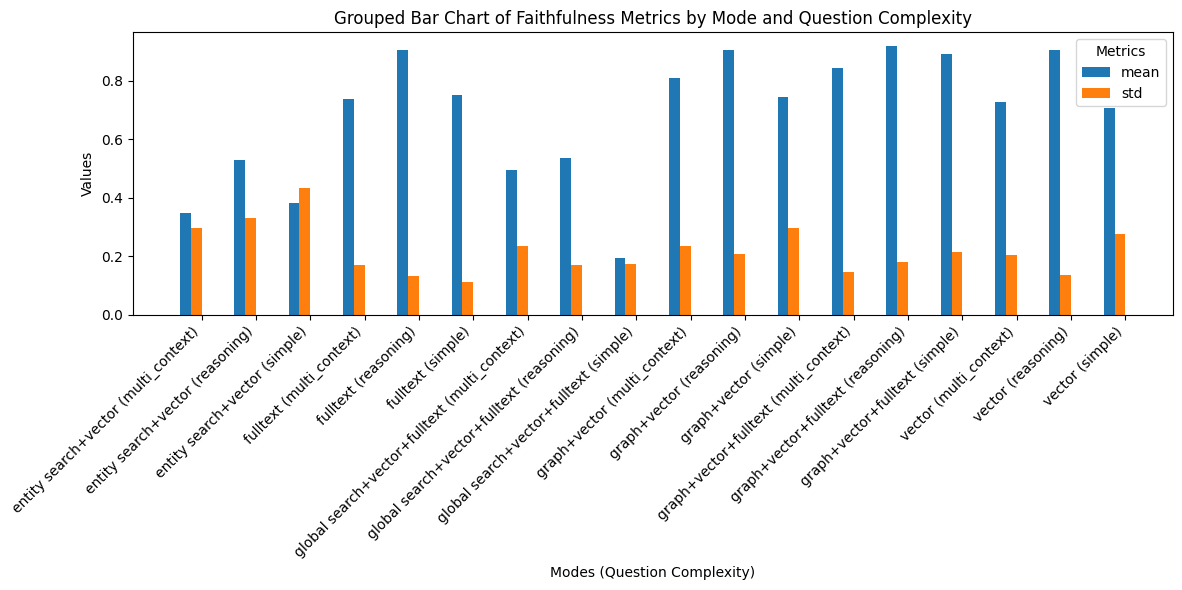

In [93]:
# Grouped bar chart
metrics = ['mean', 'std']
x = np.arange(len(faithfulness_df['mode']))  # Label locations
width = 0.2  # Bar width
fig, ax = plt.subplots(figsize=(12, 6))
for i, metric in enumerate(metrics):
   ax.bar(x + i * width, faithfulness_df[metric], width, label=metric)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(faithfulness_df['mode'] + ' (' + faithfulness_df['question_complexity'] + ')', rotation=45, ha='right')
ax.set_xlabel('Modes (Question Complexity)')
ax.set_ylabel('Values')
ax.set_title('Grouped Bar Chart of Faithfulness Metrics by Mode and Question Complexity')
ax.legend(title="Metrics")
plt.tight_layout()
plt.show()

1. Surprisingly faithfulness score is less in "entity search + vector" and "global search + vector + fulltext " modes
2. We can observe that faithfulness score increases on reasoning question for most of the modes
3. All modes struggle on simple questions.

In [112]:
# Lets check question answer for global search where it has scored low
pd.set_option("display.max_colwidth", None)
eval_df[["question","mode","answer","faithfulness"]][(eval_df['mode']=="global search+vector+fulltext") & (eval_df['faithfulness'] <0.5)]

,question,mode,answer,faithfulness
10,How does the integrated focused cost leadership strategy help competitors compete with Amazon in the book industry?,global search+vector+fulltext,"The integrated focused cost leadership strategy helps competitors like Barnes and Noble compete with Amazon in the book industry by allowing them to offer a unique value proposition. By combining cost leadership with differentiation, Barnes and Noble can focus on specific market segments or niches where they can provide distinct products or services at competitive prices. This strategy enables them to target specific customer needs effectively while maintaining cost efficiency, thereby creating a competitive advantage against Amazon's broader market approach.",0.250000
16,What is the competitive strategy of Barnes and Noble in the e-commerce industry?,global search+vector+fulltext,"Barnes and Noble in the e-commerce industry employs an integrated focused cost leadership/differentiation strategy. This strategy combines elements of cost leadership and differentiation to set itself apart from competitors like Amazon and eBay. By focusing on cost efficiency while also offering unique and differentiated products or services, Barnes and Noble aims to carve out a competitive position in the market.",0.333333
22,Why should online retailers like Amazon be careful about disclosing online sales taxes in their advertisements?,global search+vector+fulltext,"Online retailers like Amazon should be cautious about disclosing online sales taxes in their advertisements to maintain transparency and compliance with regulations. By clearly stating the inclusion of sales taxes, they build trust with customers and avoid potential legal issues related to false advertising or misleading practices. Additionally, disclosing online sales taxes helps prevent any misunderstandings or surprises for customers during the checkout process, leading to a smoother shopping experience and reducing the risk of customer dissatisfaction or complaints.",0.000000
28,How threatening are substitute products to Amazon's patented tech and customer service?,global search+vector+fulltext,"Substitute products can pose a moderate threat to Amazon's patented technology and customer service. While Amazon's patents provide a level of protection for its innovations, substitute products could still impact its market share and competitive position. Amazon's strong customer service reputation may mitigate some of this threat by fostering customer loyalty. However, continuous innovation and strategic differentiation are crucial for Amazon to stay ahead of potential substitutes in the rapidly evolving e-commerce landscape.",0.300000
57,What strategies are Amazon's book competitors using for market share and how does it compare to Amazon's?,global search+vector+fulltext,"Amazon's book competitors employ various strategies to compete for market share. eBay utilizes both cost leadership and differentiation strategies, aiming to offer competitive pricing and a unique value proposition to customers. Barnes and Noble integrates a focused cost leadership/differentiation strategy, focusing on specific market segments while offering differentiated products and services. Wal-Mart, as the world's largest retail chain, primarily focuses on a cost leadership approach, leveraging its scale to provide competitive prices.\n\nIn comparison, Amazon employs a mix of strategies, heavily investing in technologies like video content, cloud services, and its Kindle product. It leverages technologies such as Elastic Block Storage (EBS) and 1-Click Ordering to enhance operations and customer experience. Amazon's strategic focus on innovation, technology, and global market expansion sets it apart from its competitors, allowing it to maintain a strong position in the e-commerce landscape.",0.454545
69,"What strategies do Amazon's book competitors use to attract price-sensitive customers and grow market share, leveraging online shop

#### 2. Answer Relevancy

Scores the relevancy of the answer according to the given question

In [94]:
answer_rel_df = eval_df.groupby(['mode', 'question_complexity']).agg({
   'answer_relevancy': ['mean', 'min', 'max', 'std']
}).reset_index()
answer_rel_df.columns = ['mode', 'question_complexity', 'mean', 'min', 'max', 'std']
answer_rel_df

,mode,question_complexity,mean,min,max,std
0,entity search+vector,multi_context,0.944288,0.897861,0.970096,0.028123
1,entity search+vector,reasoning,0.967252,0.953466,0.985486,0.011735
2,entity search+vector,simple,0.976775,0.950704,1.000000,0.020596
3,fulltext,multi_context,0.939813,0.930814,0.955302,0.009615
4,fulltext,reasoning,0.954965,0.934895,0.974246,0.014387
5,fulltext,simple,0.969242,0.924026,1.000000,0.032231
6,global search+vector+fulltext,multi_context,0.934088,0.900393,0.967728,0.029599
7,global search+vector+fulltext,reasoning,0.953706,0.933291,0.966764,0.014332
8,global search+vector+fulltext,simple,0.975329,0.973230,0.978811,0.003037
9,graph+vector,multi_context,0.930291,0.897861,0.957943,0.026410


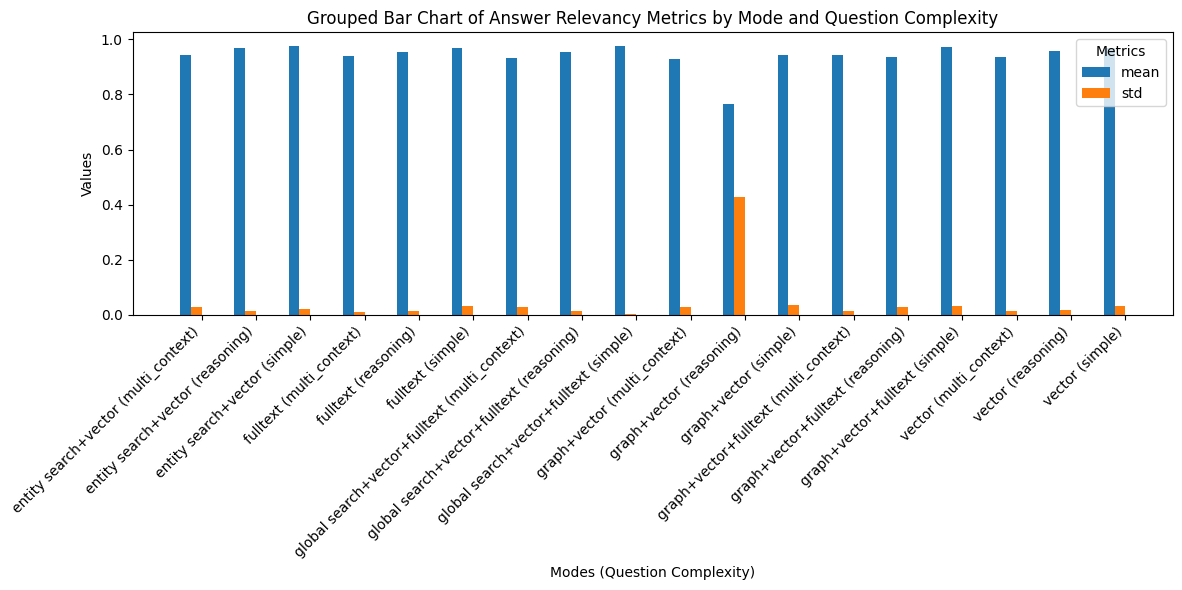

In [95]:
# Grouped bar chart
metrics = ['mean', 'std']
x = np.arange(len(answer_rel_df['mode']))  # Label locations
width = 0.2  # Bar width
fig, ax = plt.subplots(figsize=(12, 6))
for i, metric in enumerate(metrics):
   ax.bar(x + i * width, answer_rel_df[metric], width, label=metric)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(answer_rel_df['mode'] + ' (' + answer_rel_df['question_complexity'] + ')', rotation=45, ha='right')
ax.set_xlabel('Modes (Question Complexity)')
ax.set_ylabel('Values')
ax.set_title('Grouped Bar Chart of Answer Relevancy Metrics by Mode and Question Complexity')
ax.legend(title="Metrics")
plt.tight_layout()
plt.show()

1.All modes score fairly for answer relevancy  except " graph + vector " mode for reasoning questions

#### 3. Answer Correctness

Measures answer correctness compared to ground truth as a combination of factuality and semantic similarity.

In [96]:
answer_cor_df = eval_df.groupby(['mode', 'question_complexity']).agg({
   'answer_correctness': ['mean', 'min', 'max', 'std']
}).reset_index()
answer_cor_df.columns = ['mode', 'question_complexity', 'mean', 'min', 'max', 'std']
answer_cor_df

,mode,question_complexity,mean,min,max,std
0,entity search+vector,multi_context,0.742496,0.523471,0.992269,0.170004
1,entity search+vector,reasoning,0.803536,0.565711,0.943629,0.147004
2,entity search+vector,simple,0.537766,0.172675,0.733410,0.251963
3,fulltext,multi_context,0.803399,0.437395,0.995587,0.208676
4,fulltext,reasoning,0.853349,0.619032,0.996704,0.187401
5,fulltext,simple,0.672318,0.175373,0.940164,0.339199
6,global search+vector+fulltext,multi_context,0.735539,0.609525,0.909184,0.123181
7,global search+vector+fulltext,reasoning,0.727843,0.488364,0.846143,0.162029
8,global search+vector+fulltext,simple,0.394594,0.172125,0.665870,0.250464
9,graph+vector,multi_context,0.742180,0.491398,0.918170,0.188076


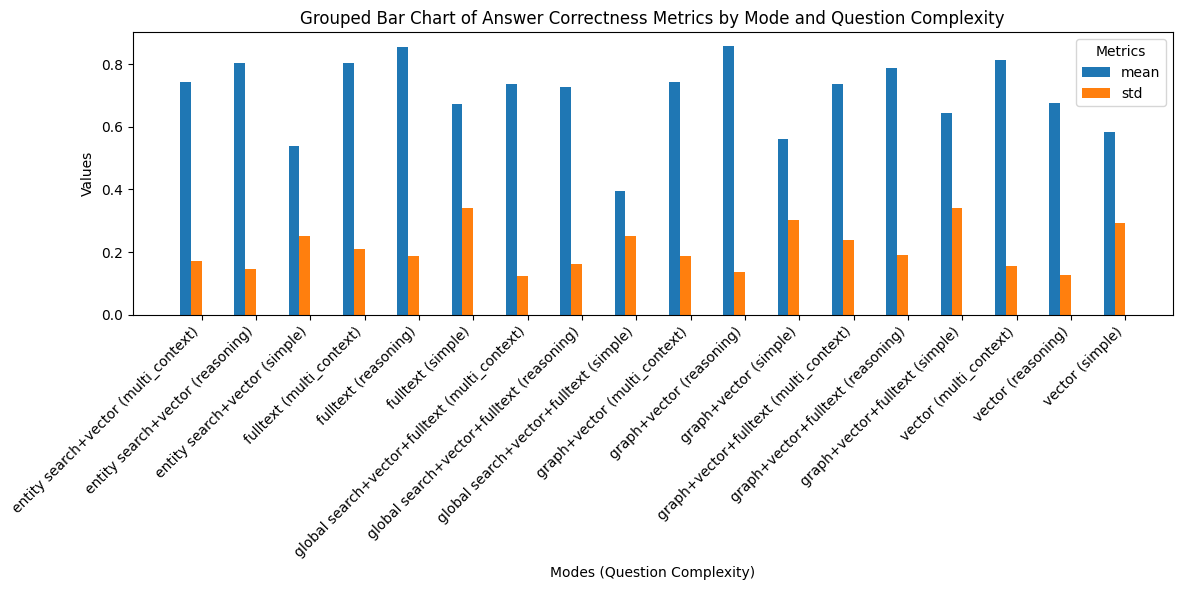

In [97]:
# Grouped bar chart
metrics = ['mean', 'std']
x = np.arange(len(answer_cor_df['mode']))  # Label locations
width = 0.2  # Bar width
fig, ax = plt.subplots(figsize=(12, 6))
for i, metric in enumerate(metrics):
   ax.bar(x + i * width, answer_cor_df[metric], width, label=metric)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(answer_cor_df['mode'] + ' (' + answer_cor_df['question_complexity'] + ')', rotation=45, ha='right')
ax.set_xlabel('Modes (Question Complexity)')
ax.set_ylabel('Values')
ax.set_title('Grouped Bar Chart of Answer Correctness Metrics by Mode and Question Complexity')
ax.legend(title="Metrics")
plt.tight_layout()
plt.show()

1. All modes struggle on simple questions

#### 4. Context Precision

Context Precision is a metric that evaluates whether all of the ground-truth relevant items present in the contexts are ranked higher or not.

In [98]:
context_precision_df = eval_df.groupby(['mode', 'question_complexity']).agg({
   'context_precision': ['mean', 'min', 'max', 'std']
}).reset_index()
context_precision_df.columns = ['mode', 'question_complexity', 'mean', 'min', 'max', 'std']
context_precision_df

,mode,question_complexity,mean,min,max,std
0,entity search+vector,multi_context,0.800000,0.0,1.0,0.447214
1,entity search+vector,reasoning,0.800000,0.0,1.0,0.447214
2,entity search+vector,simple,0.500000,0.0,1.0,0.577350
3,fulltext,multi_context,0.833333,0.0,1.0,0.408248
4,fulltext,reasoning,1.000000,1.0,1.0,0.000000
5,fulltext,simple,1.000000,1.0,1.0,0.000000
6,global search+vector+fulltext,multi_context,0.800000,0.0,1.0,0.447214
7,global search+vector+fulltext,reasoning,0.500000,0.0,1.0,0.577350
8,global search+vector+fulltext,simple,0.666667,0.0,1.0,0.577350
9,graph+vector,multi_context,0.833333,0.0,1.0,0.408248


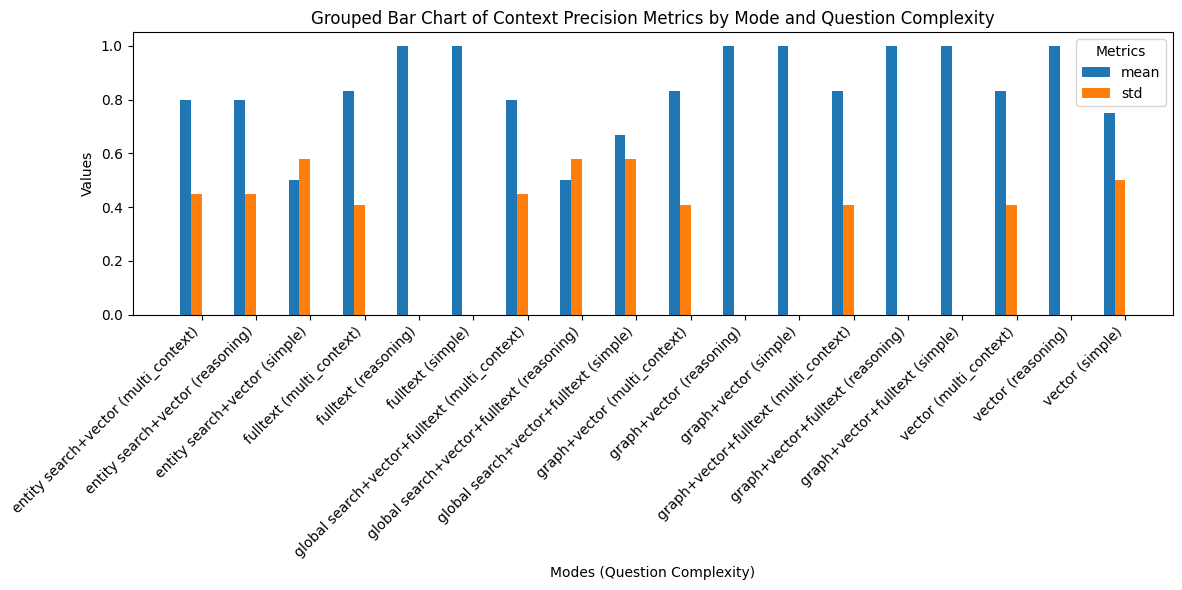

In [99]:
# Grouped bar chart
metrics = ['mean', 'std']
x = np.arange(len(context_precision_df['mode']))  # Label locations
width = 0.2  # Bar width
fig, ax = plt.subplots(figsize=(12, 6))
for i, metric in enumerate(metrics):
   ax.bar(x + i * width, context_precision_df[metric], width, label=metric)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(context_precision_df['mode'] + ' (' + context_precision_df['question_complexity'] + ')', rotation=45, ha='right')
ax.set_xlabel('Modes (Question Complexity)')
ax.set_ylabel('Values')
ax.set_title('Grouped Bar Chart of Context Precision Metrics by Mode and Question Complexity')
ax.legend(title="Metrics")
plt.tight_layout()
plt.show()

1. All modes except entity search + vector score fairly for reasoning questions .
2. As the metrics calculate context precision we can see for multi context question the score varies for all modes

#### 5. Context Recall

Context recall measures the extent to which the retrieved context aligns with the annotated answer, treated as the ground truth. It is computed using question, ground truth and the retrieved context, and the values range between 0 and 1, with higher values indicating better performance.

In [100]:
context_recall_df = eval_df.groupby(['mode', 'question_complexity']).agg({
   'context_recall': ['mean', 'min', 'max', 'std']
}).reset_index()
context_recall_df.columns = ['mode', 'question_complexity', 'mean', 'min', 'max', 'std']
context_recall_df

,mode,question_complexity,mean,min,max,std
0,entity search+vector,multi_context,0.561905,0.142857,1.0,0.310712
1,entity search+vector,reasoning,0.250000,0.000000,1.0,0.433013
2,entity search+vector,simple,0.500000,0.000000,1.0,0.577350
3,fulltext,multi_context,0.952381,0.714286,1.0,0.116642
4,fulltext,reasoning,1.000000,1.000000,1.0,0.000000
5,fulltext,simple,1.000000,1.000000,1.0,0.000000
6,global search+vector+fulltext,multi_context,0.511905,0.142857,1.0,0.341731
7,global search+vector+fulltext,reasoning,0.125000,0.000000,0.5,0.250000
8,global search+vector+fulltext,simple,0.666667,0.000000,1.0,0.577350
9,graph+vector,multi_context,0.952381,0.714286,1.0,0.116642


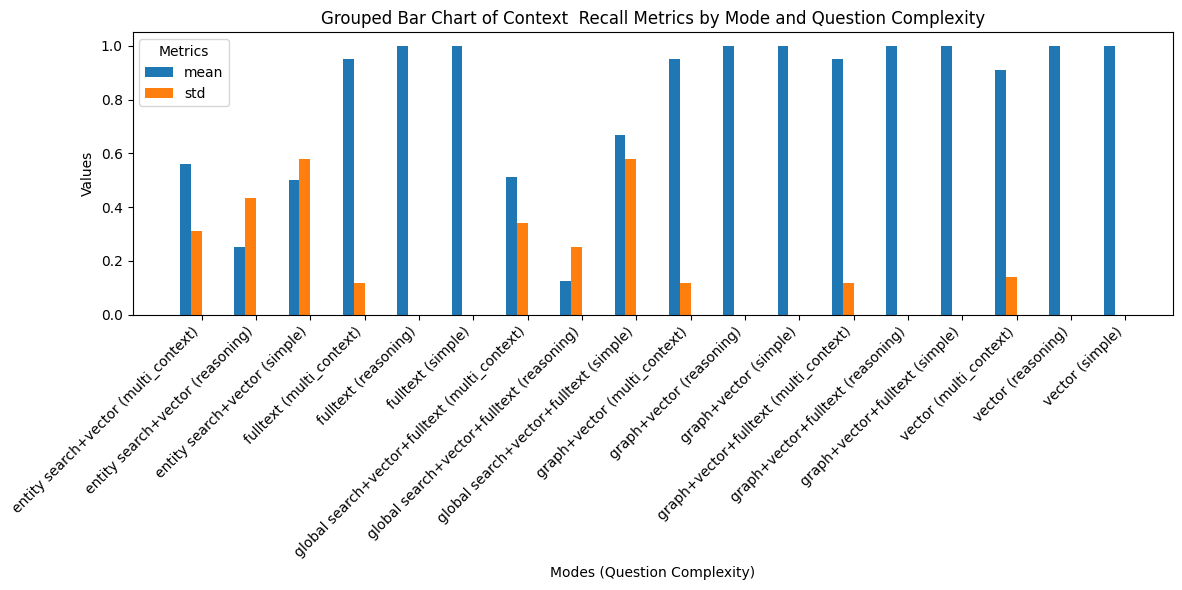

In [101]:
# Grouped bar chart
metrics = ['mean', 'std']
x = np.arange(len(context_recall_df['mode']))  # Label locations
width = 0.2  # Bar width
fig, ax = plt.subplots(figsize=(12, 6))
for i, metric in enumerate(metrics):
   ax.bar(x + i * width, context_recall_df[metric], width, label=metric)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(context_recall_df['mode'] + ' (' + context_recall_df['question_complexity'] + ')', rotation=45, ha='right')
ax.set_xlabel('Modes (Question Complexity)')
ax.set_ylabel('Values')
ax.set_title('Grouped Bar Chart of Context  Recall Metrics by Mode and Question Complexity')
ax.legend(title="Metrics")
plt.tight_layout()
plt.show()

1. "entity search + vector" and "global search + vector + fulltext " modes are performing poor for all question complexities. other modes have scored perfect score for context recall.